# mandel Q parameter

Given a stocastic variable that has mean and variace defined the mandel Q parameter is:

$
Q = \frac{\sigma_n^2}{<n>}-1
$

Here we would like to characterize the values of Q we measured during the experiments.

# Theoretical approach

Descriprion of the acquisition model:
- For each shot, we measure 100 times the number of excitated atoms in the trap, and we keep the mean and the variance.
- The duration of a measure cycle is about 1 ms.
- We assume that the channeltron makes no errors: so, what we measure is the actual number of excitated atoms in the trap.

We assume the following for each measure:

- the actual frequency of the beam changes faster than the duration of a measure cycle. So for each measure we extract the actual frequency from a gaussian centred in the value we set.

$
P(f;f_0) = \alpha e^{-\frac{(f-f_0)^2}{2\sigma_f^2}}
$
where $\alpha$ is the normalization constant.

- choosen a frequency, the number of atoms measured is distribuited as a poissonian which the mean value depend on the frequency.

$
P(n|f;f_0) = \frac{e^{-\mu (f)} \mu(f)^{n}}{n!} \text{  ;  } \mu (f)=N_{max}\frac{\gamma^2}{(\gamma^2+(f-f_r)^2)}
$

assuming that the resonance is in $f_r = 0$, where N_{max} is the peak of the lorentian and $\gamma$ is the width to half height (FWHM).
 
So, we can write the joint distribution for n and f, given $f_0$ (the value we set):

$
P(n,f;f_0) = P(n|f;f_0)P(f;f_0)=\frac{e^{-\mu (f)} \mu(f)^{n}}{n!} \alpha e^{-\frac{(f-f_0)^2}{2\sigma_f^2}}
$

Now, what we wont is $P(n;f_0)$, and we can compute it marginalizing over f:

$
P(n;f_0)=\int_{0}^{\infty} P(n,f;f_0) df = \int_{0}^{\infty} P(n|f;f_0)P(f;f_0) df = \int_{0}^{\infty} \frac{e^{-\mu (f)} \mu(f)^{n}}{n!} \alpha e^{-\frac{(f-f_0)^2}{2\sigma_f^2}} df
$

where
$
\alpha = \frac{1}{\int_{0}^{\infty} \exp{-\frac{(f-f_0)^2}{2\sigma_f^2}} df} = \frac{1}{\sqrt{2 \pi \sigma_f^2}}
$

Than, to compute the Mandel Q parameter, we need to compute the mean and the variance for n:

$
<n>=\sum_0^{\infty} n P(n;f_0) 
$

$
<n^2> = \sum_0^{\infty} n^2 P(n;f_0)
$

$
\sigma_n^2= <n^2> - <n>^2
$

$
Q = \frac{\sigma_n^2}{<n>}-1
$

##  Codes and numerical results

In [4]:
from sympy import *
import scipy.integrate as integrate
import scipy.special as special
import numpy as np
import matplotlib.pyplot as plt
from math import factorial as fact
#%matplotlib inline
#%matplotlib widget

first we define the parameters of the simulation

In [39]:
## n_max : height of the peack of the ideal lorentian. 
n_max = 6

## g : FWHM of the ideal lorentian.
g = 1.7 # 2*780/1013-0.6

## f_std : standard deviation of the frequency gaussian noise.
f_std = 0.7

## f0_vals : values of detuning to sample all the lorentian.
f0_vals = np.linspace(0, 8, 100)

## df : define the width of the integration interval.
df = 10

## term_contribution_bound : sets when to troncate the moments sum.
term_contribution_bound = 0.0005

In [40]:
## defining the lorentian function
def lorentian(x, n_max, Gamma, x_resonance=0):
    #return n_max*(Gamma**2/((x-x_resonance)**2+Gamma**2))
    return n_max*np.e**(-(x-x_resonance)**2/(2*Gamma**2))

## defining the gaussian constant
def gaussian(x, mean, std, norm_constant):
    return norm_constant*exp(-(x-mean)**2/(2*std**2))

## defining the gaussian constant
def uniform(x, low, high):
    if x < high and x > low:
        return 1/(high-low)
    return 0

## defining the probability function: computes the probability of have "n" atoms with a setted frequency "f0".
def probability(n, f0, df, prior = "gaussian"):
    if prior == "gaussian":
        alpha = 1/sqrt(2*pi*f_std**2)
        integrating = lambda f: gaussian(f, f0, f_std, alpha)*exp(-lorentian(f,n_max,g))*lorentian(f, n_max, g)**n/fact(n)
        
        res = integrate.quad(integrating, f0-df, f0+df) ## integrate returns 2 values: res[0] is the value of the integral, res[1] is the numerical uncertainty.
        return res[0]
    if prior == "uniform":
        integrating = lambda f: uniform(f,f0-f_std,f0+f_std)*exp(-lorentian(f,n_max,g))*lorentian(f, n_max, g)**n/fact(n)
        df=f_std
        res = integrate.quad(integrating, f0-df, f0+df) ## integrate returns 2 values: res[0] is the value of the integral, res[1] is the numerical uncertainty.
        return res[0]
    
    return "error"

In [41]:
## will contain the Q and the <n> values respectively for each f0 in f0_vals.
Q=[] 
n_means = []  

for f0 in f0_vals:
    n_mean = 0
    n2_mean = 0
    
    i=0
    p_aus=1
    while (p_aus*i**2 > term_contribution_bound) or (i < n_max):
        p_aus=probability(i,f0, df, prior="gaussian")
        n_mean+=i*p_aus
        n2_mean+=(i**2)*p_aus
        
        i+=1
        
    #n_mean2=lorentian(f0,n_max,g)
    n_means.append(n_mean)
    Q.append((n2_mean-n_mean**2)/n_mean-1)

    

Next data are saved in a file, so that one can plot them enytime.

In [23]:
nome="freq_jitter02"
#f=open("dati/"+nome,"w")

f.write("#n_max:%.4f g:%.4f f_std:%.4f\n" %(n_max, g, f_std))
for i in range(len(f0_vals)):
    f.write("%.5f %.5f %.5f\n" %(f0_vals[i], Q[i], n_means[i]))
f.close()


NameError: name 'f' is not defined

Then we plot the results.

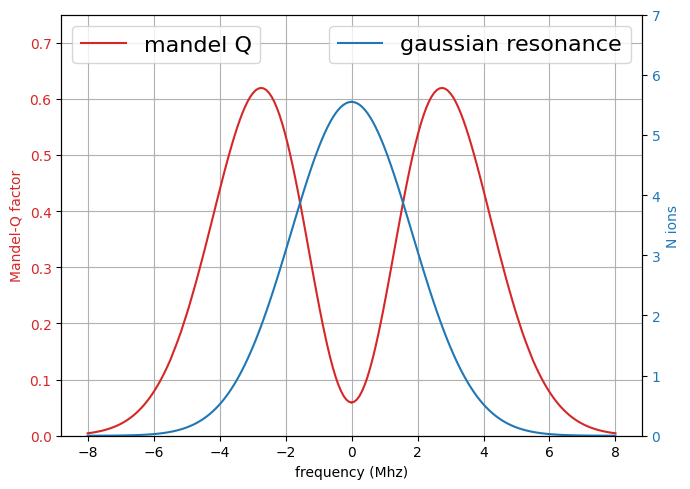

In [44]:
y=lorentian(f0_vals,n_max,g)

fig, ax1 = plt.subplots(figsize=(7, 5))

color = 'tab:red'
ax1.set_xlabel('frequency (Mhz)')
ax1.set_ylabel('Mandel-Q factor', color=color)
ax1.plot(f0_vals, Q, "-", color=color, label="mandel Q")
ax1.plot(-f0_vals, Q, "-", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0,0.75])#max(Q)+0.05])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('N ions', color=color)  # we already handled the x-label with ax1
ax2.plot(f0_vals, n_means, "-", color=color, label="gaussian resonance")
ax2.plot(-f0_vals, n_means, "-", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0,n_max+1])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.grid()

#plt.plot(f0_vals, y, c="b", label="ideal lorentian")
#plt.plot(-f0_vals, y, c="b")
ax1.legend(loc=2, fontsize=16)
ax2.legend(loc=1, fontsize=16)

#text=""
#text=text+"width to half height = %.2f (Mhz)\n" %g
#text=text+"N max = %d (atoms)\n" %n_max
#text=text+"frequency jitter std = %.2f (Mhz)\n" %f_std

#ax2.text(x=5,y=1.5,s=text,backgroundcolor="y")

plt.show()

#  With a jitter also on the amplitude (power) of the beam



Now we assume the same model of the latter, but introducing also the jitter on the amplitude of the beam.

We assume that a fluctation of the amplitude is proportional to a fluctation on the maximum number of atoms of the lorentian of the resonance, also it we assume be gaussian:

$
P(n|f,A;f_0,A_0) = \frac{e^{-\mu (f,A)} \mu(f,A)^{n}}{n!} \text{  ;  } \mu (f,A)=AN_{max}\frac{\gamma^2}{(\gamma^2+f^2)}
$

$
P(f,A;f_0,A_0)=P(f;f_0)P(A;A_0)=\frac{1}{\sqrt{2 \pi \sigma_f^2}}e^{-\frac{(f-f_0)^2}{2\sigma_f^2}}\frac{1}{\sqrt{2 \pi \sigma_A^2}}e^{-\frac{(A-A_0)^2}{2\sigma_A^2}}
$

Following the same reasoning of before we can do this calculus:

$
P(n;f_0,A_0) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} P(n|f,A;f_0,A_0)P(f;f_0)P(A;A_0) df dA = \int_{-\infty}^{\infty}  \int_{-\infty}^{\infty} \frac{e^{-\mu (f,A)} \mu(f,A)^{n}}{n!} \frac{1}{\sqrt{2 \pi \sigma_f^2}}e^{-\frac{(f-f_0)^2}{2\sigma_f^2}}\frac{1}{\sqrt{2 \pi \sigma_A^2}}e^{-\frac{(A-A_0)^2}{2\sigma_A^2}} df dA
$

In [2]:
## n_max : height of the peack of the ideal lorentian. 
n_max = 6

## g : FWHM of the ideal lorentian.
g = 2*780/1013-0.6
print(g)

## f_std : standard deviation of the frequency gaussian noise.
f_std = 0.6

## A_std : standard deviation of the amplitude gaussian noise.
A_std = 0.1

## f0_vals : values of detuning to sample all the lorentian.
f0_vals = np.linspace(0, 6, 10)

## A0_val : mean value of aplitude of the beam.
A0_val = 1

## df : define the width of the integration interval.
df = 10

## df : define the width of the integration interval.
dA = A_std

## term_contribution_bound : sets when to troncate the moments sum.
term_contribution_bound = 0.0005

0.939980256663376


In [3]:
## defining the lorentian function
def lorentian(x, n_max, Gamma, x_resonance=0):
    return n_max*(Gamma**2/((x-x_resonance)**2+Gamma**2))

## defining the gaussian constant
def gaussian(x, mean, std, norm_constant):
    return norm_constant*exp(-(x-mean)**2/(2*std**2))

## defining the uniform function
def uniform(x, low, high):
    if x < high and x > low:
        return 1/(high-low)
    return 0

def function(f, f0, f_std, alpha_f=1, type="gaussian"):
    if type == "gaussian":
        return gaussian(f, f0, f_std, alpha_f)
    if type == "uniform":
        return uniform(f, f0-f_std, f0+f_std)
    return "error"

## defining the probability function: computes the probability of have "n" atoms with a setted frequency "f0".
def probability(n, f0, A0, f_std, A_std, df, dA, prior_f="gaussian", prior_A="gaussian"):
        
    alpha_f = 1/sqrt(2*pi*f_std**2)
    alpha_A = 1/sqrt(2*pi*A_std**2)
    
    integrating = lambda f, A: function(f, f0, f_std, alpha_f, type=prior_f)*function(A, A0, A_std, alpha_A, type=prior_A)*exp(-lorentian(f,n_max*A,g))*lorentian(f, n_max*A, g)**n/fact(n)
    res = integrate.dblquad(integrating, A0-dA, A0+dA, f0-df, f0+df) ## integrate returns 2 values: res[0] is the value of the integral, res[1] is the numerical uncertainty.

    return res[0]

In [4]:
## will contain the Q and the <n> values respectively for each f0 in f0_vals.
Q=[] 
n_means = []  

j=0
for f0 in f0_vals:
    print(j)
    n_mean = 0
    n2_mean = 0
    
    i=0
    p_aus=1
    while (p_aus*i**2 > term_contribution_bound) or (i < n_max):
        p_aus=probability(i, f0, A0_val, f_std, A_std, df, dA, prior_f="gaussian", prior_A="uniform")
        
        n_mean+=i*p_aus
        n2_mean+=i**2*p_aus
        #print(i, p_aus, p_aus*i**2, n_mean, f0)

        i+=1

    n_means.append(n_mean)
    if n_mean!=0:
        Q.append((n2_mean-n_mean**2)/n_mean-1)
    else:
        Q.append(0)
    
    j+=1

0
1
2
3
4
5
6
7
8
9


In [5]:
nome="freq_and_amp_jitter01"
#f=open("dati/"+nome,"w")

f.write("#n_max:%.4f g:%.4f f_std:%.4f A_std:%.4f\n" %(n_max, g, f_std, A_std))
for i in range(len(f0_vals)):
    f.write("%.5f %.5f %.5f\n" %(f0_vals[i], Q[i], n_means[i]))
f.close()

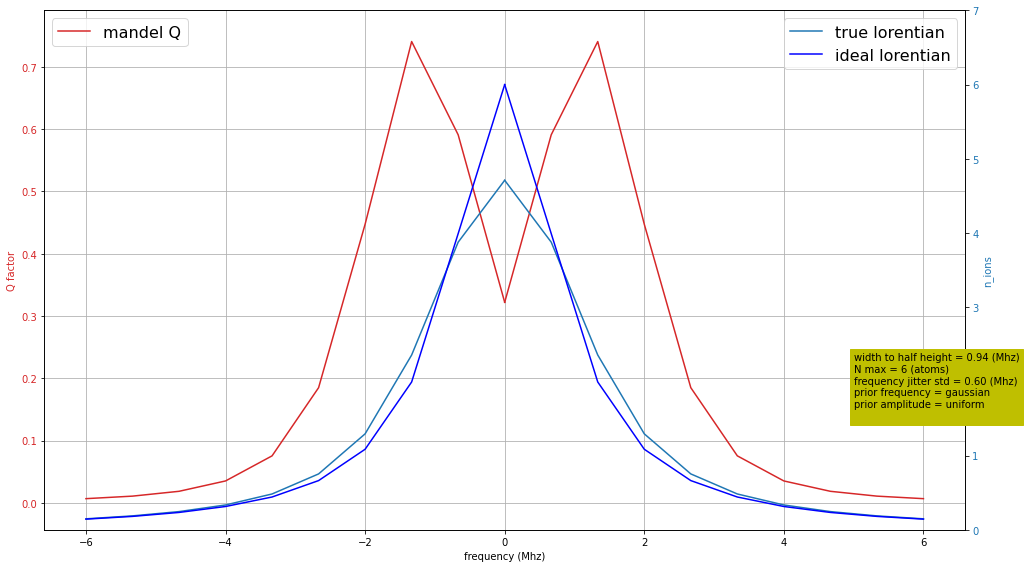

In [6]:
y=lorentian(f0_vals,n_max,g)

fig, ax1 = plt.subplots(figsize=(14, 8))

color = 'tab:red'
ax1.set_xlabel('frequency (Mhz)')
ax1.set_ylabel('Q factor', color=color)
ax1.plot(f0_vals, Q, "-", color=color, label="mandel Q")
ax1.plot(-f0_vals, Q, "-", color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([min(Q)-0.05,max(Q)+0.05])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('n_ions', color=color)  # we already handled the x-label with ax1
ax2.plot(f0_vals, n_means, "-", color=color, label="true lorentian")
ax2.plot(-f0_vals, n_means, "-", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0,n_max+1])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.grid()

plt.plot(f0_vals, y, c="b", label="ideal lorentian")
plt.plot(-f0_vals, y, c="b")
ax1.legend(loc=2, fontsize=16)
ax2.legend(loc=1, fontsize=16)

text=""
text=text+"width to half height = %.2f (Mhz)\n" %g
text=text+"N max = %d (atoms)\n" %n_max
text=text+"frequency jitter std = %.2f (Mhz)\n" %f_std
text=text+"prior frequency = gaussian\n"
text=text+"prior amplitude = uniform\n"

ax2.text(x=5,y=1.5,s=text,backgroundcolor="y")

plt.show()

(0.020650156413968723, 6.263321225149154e-09)

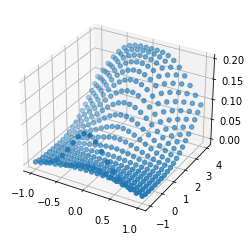

In [30]:
n=4
integrating = lambda x, y: exp(-lorentian(x,y,1))*lorentian(x,y,1)**n/fact(n)

x=np.linspace(-1,1,20)
y=np.linspace(-1,4,20)
X, Y = np.meshgrid(x, y)
z=[integrating(x_,y_) for (x_, y_) in zip(np.ravel(X), np.ravel(Y))]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X, Y, z)

res = integrate.dblquad(integrating, -1,1,-1,1) 

res